## 0. Download CROCO dataset from Zenodo

The entire dataset is less than 1 GB.

In [15]:
import os
import shutil
import urllib

def download_CROCO_file(file_name):
    # download the data
    url = 'https://zenodo.org/record/18469910/files/'
    destination_path = f"../data/{file_name}"
    if not os.path.exists(destination_path):
        print(f"File '{file_name}' being downloaded to {destination_path}.")
        with urllib.request.urlopen(url + file_name) as response, open(destination_path, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f"File '{file_name}' has completed download to {destination_path}.")
    else:
        print(f"File '{file_name}' already exists at {destination_path}. Skipping download.")
    return destination_path

def download_CROCO_dataset():
    for file_name in [
        "CROCO_rrexnums_grd.nc",
        "CROCO_rrexnum200_his.00000.nc",
        "CROCO_rrexnum200_avg.00000.nc",
        "CROCO_rrexnum200_diaT_avg.00000.nc"
    ]:
        download_CROCO_file(file_name)

In [16]:
download_CROCO_dataset()

File 'CROCO_rrexnums_grd.nc' already exists at ../data/CROCO_rrexnums_grd.nc. Skipping download.
File 'CROCO_rrexnum200_his.00000.nc' already exists at ../data/CROCO_rrexnum200_his.00000.nc. Skipping download.
File 'CROCO_rrexnum200_avg.00000.nc' already exists at ../data/CROCO_rrexnum200_avg.00000.nc. Skipping download.
File 'CROCO_rrexnum200_diaT_avg.00000.nc' already exists at ../data/CROCO_rrexnum200_diaT_avg.00000.nc. Skipping download.


## 1. Load CROCO data and set up `xgcm.Grid` instance

In [17]:
import xarray as xr
import xgcm
import roms_tools
import xwmt

def assign_grid_coords(ds, og):
    
    ds = ds.assign_coords({v.name:v for v in ds.data_vars.values() if len(v.dims) < 3})
    ds = ds.assign_coords({k:v for (k,v) in og.data_vars.items()})
    ds = ds.rename({"sc_r": "sigma_r", "sc_w":"sigma_w"})

    # Add necessary grid metrics and coordinates
    ds = ds.assign_coords({
        'areacello': (1/ds.pm)*(1/ds.pn),
        'dx_rho': 1/ds.pm,
        'dy_rho': 1/ds.pn,
        'lon': ds.lon_rho,
        'lat': ds.lat_rho,
        'geolon_c': ds.lon_psi,
        'geolat_c': ds.lat_psi
    })

    ds = ds.isel({
        "xi_rho":slice(1, ds.xi_rho.size-1),
        "eta_rho":slice(1, ds.eta_rho.size-1),
        "eta_u":slice(1, ds.eta_u.size-1),
        "xi_v":slice(1, ds.xi_v.size-1),
    })

    ds = ds.squeeze("one")

    return ds

def create_roms_grid(ds):
    coords = {
        'X': {'center':  'xi_rho', 'outer':  f'xi_psi'},
        'Y': {'center': 'eta_rho', 'outer': f'eta_psi'},
        'Z': {'center':   's_rho', 'outer':   's_w'  }
    }
    boundary = {'X':'extend', 'Y':'extend', 'Z':'extend'}
    grid = xgcm.Grid(
        ds,
        coords=coords,
        boundary=boundary,
        metrics={("X","Y"):["areacello"]},
        autoparse_metadata=False
    )

    grid._ds = grid._ds.assign_coords({
        'dy_u': grid.interp(grid._ds.dy_rho.chunk({'xi_rho':-1}), 'X'),
        'dx_v': grid.interp(grid._ds.dx_rho.chunk({'eta_rho':-1}), 'Y')
    })

    return grid

def infer_thkcello(ds):
    ds["z_l"] = roms_tools.vertical_coordinate.compute_depth_coordinates(
        ds,
        depth_type="layer",
        location="rho",
        zeta=ds.zeta
    )
    
    ds["z_i"] = roms_tools.vertical_coordinate.compute_depth_coordinates(
        ds,
        depth_type="interface",
        location="rho",
        zeta=ds.zeta
    )
    grid = create_roms_grid(ds)
    
    ds["thkcello"] = -grid.diff(ds.z_i, "Z", boundary="extend")

    return ds

def swap_redundant_dimensions(ds):
    coord_remapping = {
        "xi_u":"xi_psi",
        "eta_v":"eta_psi",
        "xi_v":"xi_rho",
        "eta_u":"eta_rho"
    }

    for k,v in {**ds.data_vars, **ds.coords}.items():
        for c, c_new in coord_remapping.items():
            if c in v.dims:
                ds[k] = ds[k].swap_dims({c:c_new})

    ds = ds.assign_coords({
        c: xr.DataArray(ds[c].values, dims=(c_new,))
        for c, c_new in coord_remapping.items()
        if c in ds.coords
    })

    ds = ds.drop_dims([c for c in coord_remapping.keys() if c in ds.dims])

    return ds

def load_data():
    # Load static grid file
    og = xr.open_dataset("../data/CROCO_rrexnums_grd.nc")
    
    # Load instantaneous snapshots
    ds_snap = xr.open_dataset("../data/CROCO_rrexnum200_his.00000.nc")
    ds_snap = assign_grid_coords(ds_snap, og)
    ds_snap = infer_thkcello(ds_snap)

    # Compute potential density snapshots
    wm_snap = xwmt.WaterMass(
        create_roms_grid(ds_snap), 
        t_name='temp',
        s_name='salt'
    )
    ds_snap["sigma2"] = wm_snap.get_density("sigma2")

    ds_snap = ds_snap.rename({
        **{'time':'time_bounds'},
        **{v:f"{v}_bounds" for v in ds_snap.data_vars}
    })
    
    ds_avg = xr.open_dataset("../data/CROCO_rrexnum200_avg.00000.nc")
    ds_avg = assign_grid_coords(ds_avg, og)

    ds_dia = xr.open_dataset("../data/CROCO_rrexnum200_diaT_avg.00000.nc")
    ds_dia = assign_grid_coords(ds_dia, og)

    ds = xr.merge([ds_avg, ds_dia])
    ds = infer_thkcello(ds)

    # Compute time-averaged potential density
    wm = xwmt.WaterMass(
        create_roms_grid(ds), 
        t_name='temp',
        s_name='salt'
    )
    ds["sigma2"] = wm.get_density("sigma2")

    ds = xr.merge([ds, ds_snap], compat="override")

    ds = swap_redundant_dimensions(ds)
    
    return ds

In [18]:
ds = load_data()
grid = create_roms_grid(ds)
ds = grid._ds # overwrite ds with the version inside of the grid object

## 2. Add derived diagnostics

In [19]:
rho0 = 1035.
grid._ds["umo"] = (rho0*(ds.u*ds.dy_u)*grid.interp(ds.thkcello, "X"))
grid._ds["vmo"] = (rho0*(ds.v*ds.dx_v)*grid.interp(ds.thkcello, "Y"))

## 3. Load the CROCO.yaml file

Ignore the warnings about missing "*tend" and "*adv* budget tendency diagnostics. These are required to close the CROCO heat and salt budgets, but are not required for water mass budget calculations, since they are implicit in the left-hand-side (mass tendencies and mass transports).

In [20]:
import xbudget
xbudget_dict = xbudget.load_yaml("CROCO.yaml")
xbudget.collect_budgets(grid, xbudget_dict)

/opt/anaconda3/envs/xwmb_examples/lib/python3.12/site-packages/xbudget/collect.py:228: UserWarning: Variable temp_rate is missing from the dataset `ds`, so it is being skipped. To suppress this warning, remove temp_rate from the `xbudget_dict`.
  warnings.warn(f"Variable {v_term} is missing from the dataset `ds`, so it is being skipped. To suppress this warning, remove {v_term} from the `xbudget_dict`.")
/opt/anaconda3/envs/xwmb_examples/lib/python3.12/site-packages/xbudget/collect.py:228: UserWarning: Variable temp_xadv is missing from the dataset `ds`, so it is being skipped. To suppress this warning, remove temp_xadv from the `xbudget_dict`.
  warnings.warn(f"Variable {v_term} is missing from the dataset `ds`, so it is being skipped. To suppress this warning, remove {v_term} from the `xbudget_dict`.")
/opt/anaconda3/envs/xwmb_examples/lib/python3.12/site-packages/xbudget/collect.py:228: UserWarning: Variable temp_yadv is missing from the dataset `ds`, so it is being skipped. To supp

In [21]:
import numpy as np
sigma2_bin_edges = np.linspace(34.5, 37.0, 100)
grid._ds = grid._ds.assign_coords({
    "sigma2_i_target": xr.DataArray(sigma2_bin_edges, dims=("sigma2_i_target",)),
    "sigma2_l_target": xr.DataArray((sigma2_bin_edges[1:] + sigma2_bin_edges[:-1])/2, dims=("sigma2_l_target",))
})

In [22]:

import xwmt
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

In [23]:
import xwmb
wmb = xwmb.WaterMassBudget(
    grid,
    xbudget_dict,
    region=xr.ones_like(ds.areacello),
    rebin=True
)

### Stratification for context

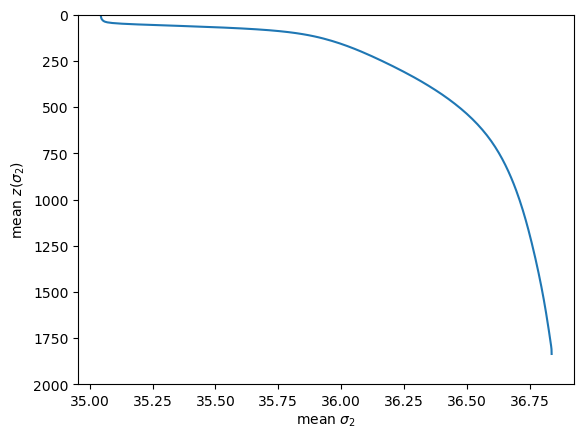

In [24]:
sigma2_mean_profile = grid._ds.sigma2.mean(["xi_rho", "eta_rho", "time"])
z_l_mean_profile = grid._ds.z_l.mean(["xi_rho", "eta_rho", "time"])

import matplotlib.pyplot as plt
plt.plot(sigma2_mean_profile, z_l_mean_profile)
plt.ylim(2000, 0)
plt.xlabel(r"mean $\sigma_{2}$")
plt.ylabel(r"mean $z(\sigma_{2})$");

## Water mass transformation budget analysis

In [25]:
wmt = wmb.mass_budget("sigma2", greater_than=True);
Sv_per_kgpers = 1e-6/rho0

(37.0, 34.5)

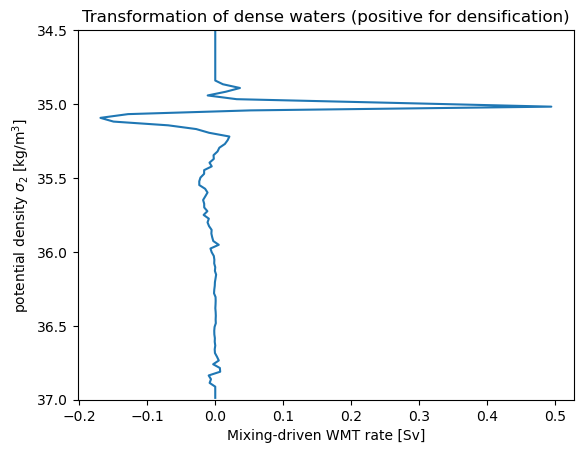

In [26]:
wmt_diff = wmt.diffusion.compute()
(wmt_diff.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Mixing-driven WMT rate [Sv]")
plt.title("Transformation of dense waters (positive for densification)")
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.ylim(37.0, 34.5)

(37.0, 34.5)

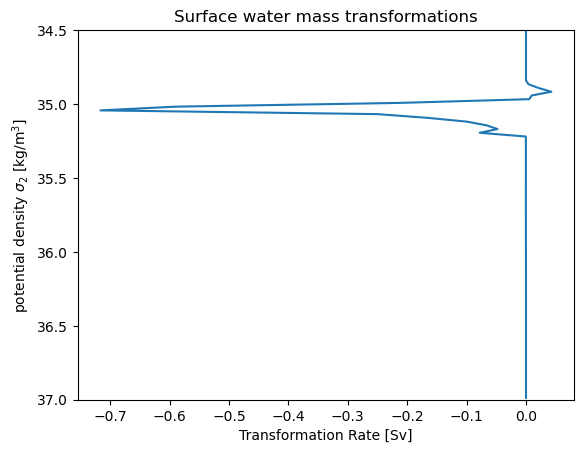

In [27]:
wmt_surface = wmt.boundary_fluxes.compute()

Sv_per_kgpers = 1e-6/rho0
(wmt_surface.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Transformation Rate [Sv]")
plt.title("Surface water mass transformations")
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.ylim(37.0, 34.5)

(37.0, 34.5)

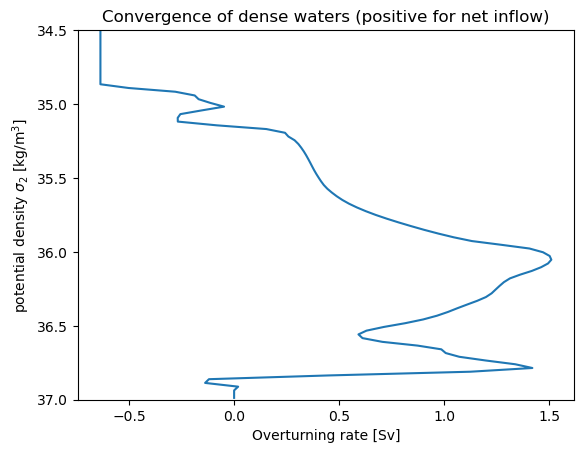

In [28]:
psi = wmt.convergent_mass_transport.compute()

Sv_per_kgpers = 1e-6/rho0
(psi.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Overturning rate [Sv]")
plt.title("Convergence of dense waters (positive for net inflow)")
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.ylim(37.0, 34.5)

(37.0, 34.5)

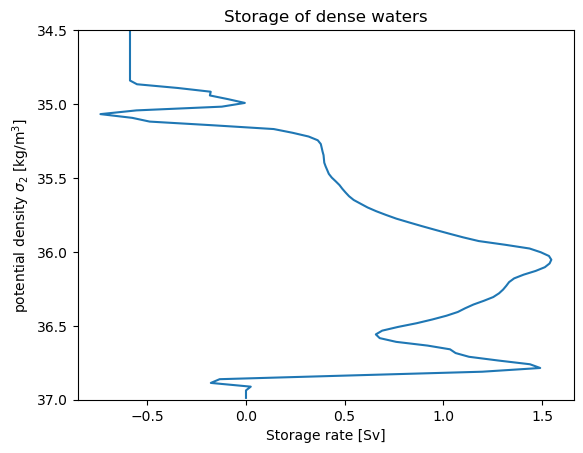

In [31]:
dMdt = wmt.mass_tendency.compute()

Sv_per_kgpers = 1e-6/rho0
(dMdt.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Storage rate [Sv]")
plt.title("Storage of dense waters")
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.ylim(37.0, 34.5)

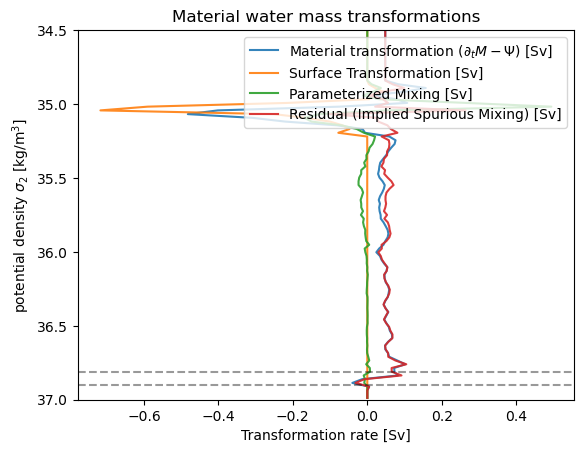

In [32]:
Sv_per_kgpers = 1e-6/rho0
((dMdt - psi).mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label=r"Material transformation ($\partial_{t} M - \Psi$) [Sv]", alpha=0.9)
(wmt_surface.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Surface Transformation [Sv]", alpha=0.9)
(wmt_diff.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Parameterized Mixing [Sv]", alpha=0.9)
spurious_mixing = (dMdt - psi - wmt_diff - wmt_surface)
(spurious_mixing.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Residual (Implied Spurious Mixing) [Sv]", alpha=0.9)
plt.axhline(36.815, color="k", ls="--", alpha=0.4)
plt.axhline(36.9, color="k", ls="--", alpha=0.4)
plt.xlabel("Transformation rate [Sv]")
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.title("Material water mass transformations")
plt.ylim(37.0, 34.5)
plt.legend()